# Camera Calibration with OpenCV

this notebook gives an introduction in finding parameters in an image like distortion, intrinsic and extrinsic parameters. 
The code is based on the [openCV_tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)


# Load images

the images are taken from the OpenCV samples data. Unfortunately these images can not be accessed directly from the OpennCV-python module in this notebook. Hence, the files must be loaded from the base github repository: 'iubh/DLMAIEAIS01_DEV'.

**@ToDo:**  the final repository must content all necessary source files and must have pubilc access.
If the access is not publi, the files can't get downloaded properly.

In [ ]:
# load pictures from github repository to colab
#
# 
# files: left01.jpg ... left09.jpg + left11.jpg...left14.jpg
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left01.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left02.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left03.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left04.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left05.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left06.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left07.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left08.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left09.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left11.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left12.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left13.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left14.jpg
#

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27908  100 27908    0     0   184k      0 --:--:-- --:--:-- --:--:--  182k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28611  100 28611    0     0   176k      0 --:--:-- --:--:-- --:--:--  176k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29553  100 29553    0     0   225k      0 --:--:-- --:--:-- --:--:--  225k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25150  100 25150    0     0   219k      0 --:--:-- --:--:-- --:--:--  219k
  % Total    % Received % Xferd  Average Speed   Tim

# Setup

import resources and load all available images with ``glob.glob()``.
The jupyter-notebook must replace the ``cv2.imshow()`` function with the function ``cv2_imshow()``


In [ ]:
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow  # a replacement for the cv2.imshow() function to use in jupyter-notebooks

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [ ]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
detailed module description: [lib/glob.py](https://docs.python.org/3/library/glob.html)

In [ ]:
images = glob.glob('*.jpg')
images

['left12.jpg',
 'left02.jpg',
 'left14.jpg',
 'left06.jpg',
 'left07.jpg',
 'left13.jpg',
 'left05.jpg',
 'left11.jpg',
 'left03.jpg',
 'left08.jpg',
 'left09.jpg',
 'left04.jpg',
 'left01.jpg']

So to find pattern in chess board, we use the function, cv2.findChessboardCorners(). We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. (Normally a chess board has 8x8 squares and 7x7 internal corners). It returns the corner points and retval which will be True if pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom)
Once we find the corners, we can increase their accuracy using cv2.cornerSubPix(). We can also draw the pattern using cv2.drawChessboardCorners().

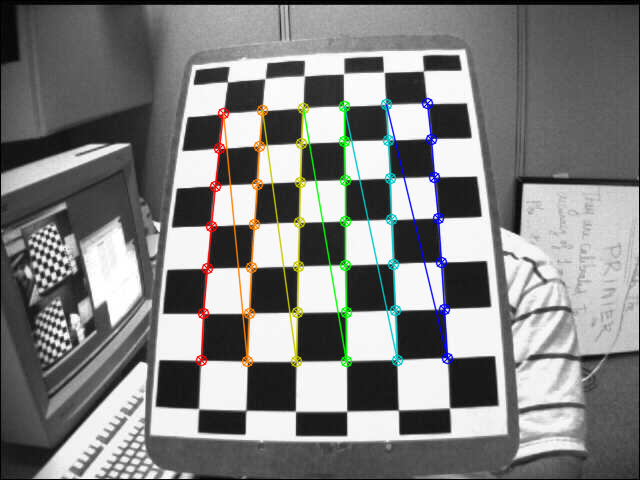

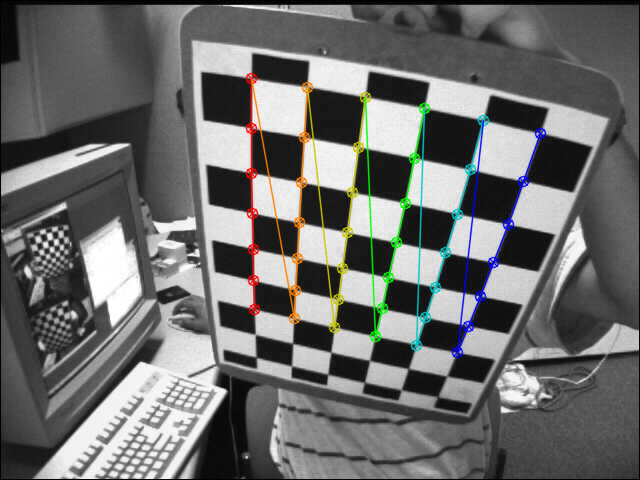

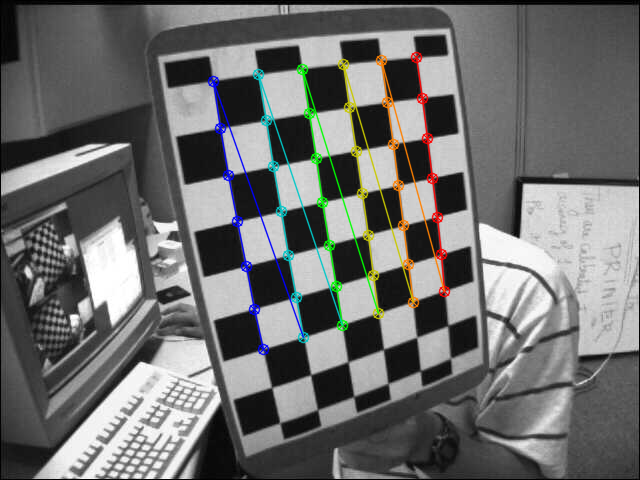

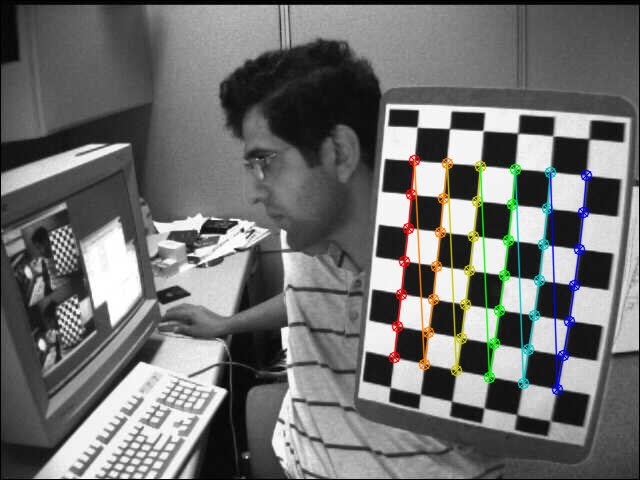

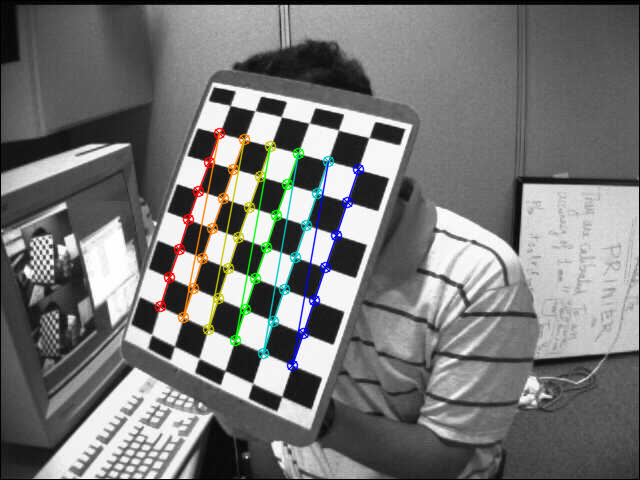

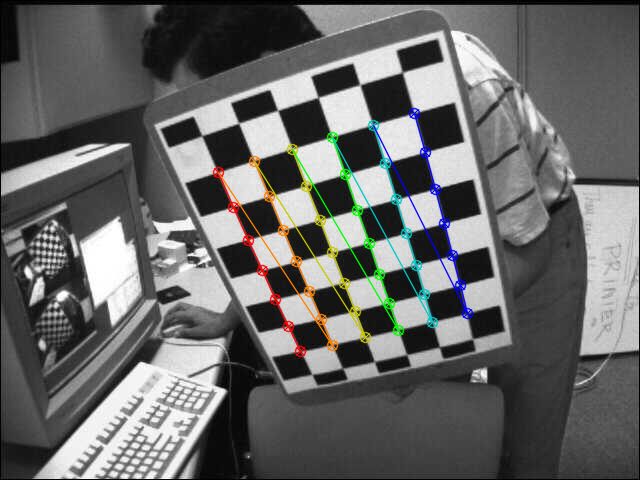

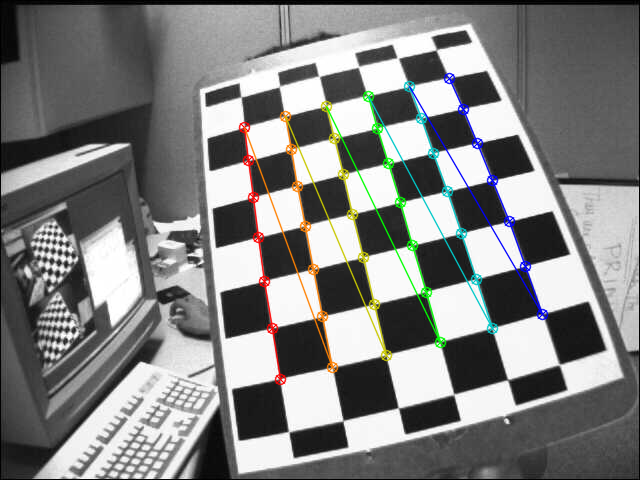

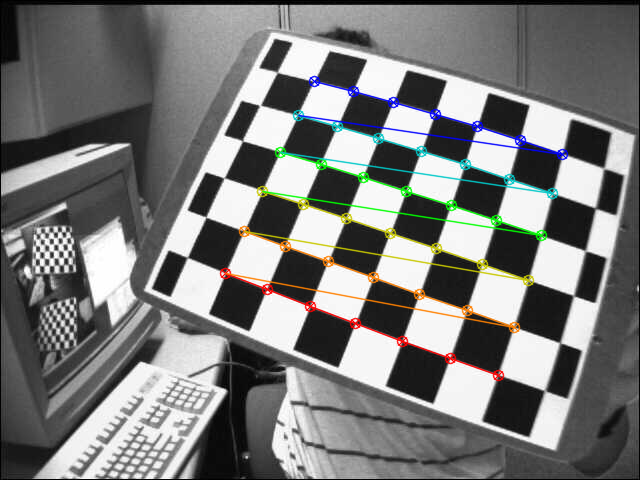

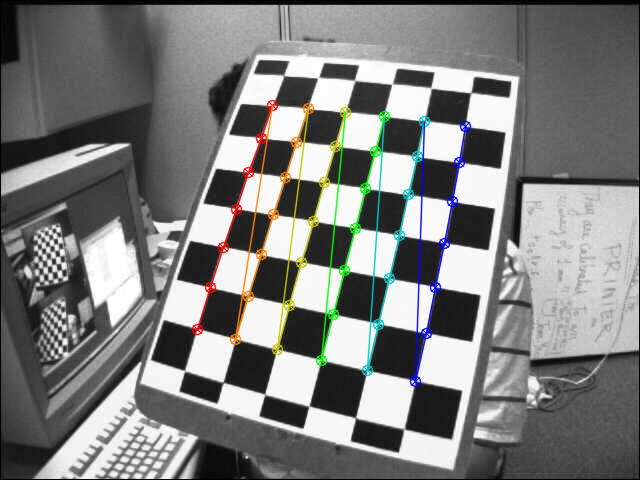

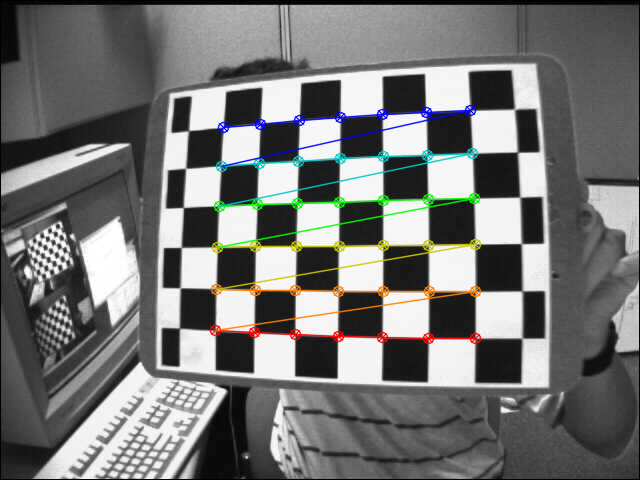

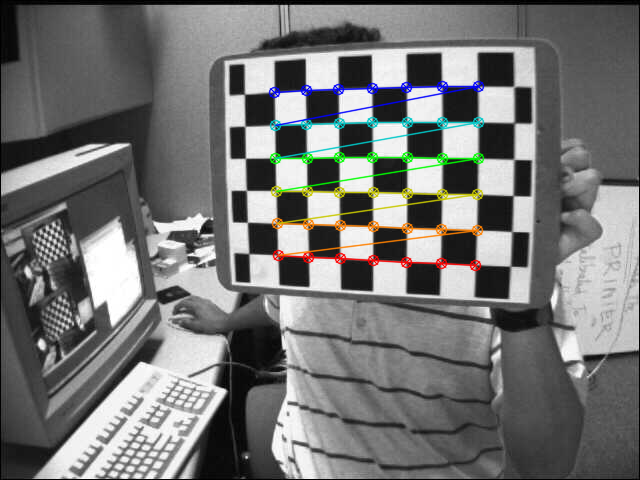

In [ ]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2_imshow(img)
        cv2.waitKey(1000)

cv2.destroyAllWindows()

# Calibration

So now we have our object points and image points we are ready to go for calibration. For that we use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.



In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


0.1553690091859444
[[534.07088623   0.         341.53407107]
 [  0.         534.11914798 232.94565221]
 [  0.           0.           1.        ]]
[[-2.92971621e-01  1.07706887e-01  1.31038490e-03 -3.11022978e-05
   4.34799142e-02]]
[array([[-0.35367632],
       [-0.24363034],
       [-1.56874295]]), array([[ 0.41531697],
       [ 0.65664498],
       [-1.3373494 ]]), array([[-0.17288944],
       [-0.4676468 ],
       [ 1.34745198]]), array([[-0.29979222],
       [ 0.39216378],
       [-1.4348239 ]]), array([[-0.32034626],
       [ 0.15979932],
       [-1.24149595]]), array([[ 0.30697387],
       [ 0.50385522],
       [-1.82824733]]), array([[-0.45993979],
       [-0.31420179],
       [-1.76122223]]), array([[-0.26451431],
       [-0.39360849],
       [-2.74787378]]), array([[-0.45883216],
       [-0.08848876],
       [-1.33510786]]), array([[-0.37843359],
       [-0.18064237],
       [-3.11615995]]), array([[-0.43239601],
       [ 0.25603401],
       [-3.08832021]])]
[array([[-2.8998548

We have got what we were trying. Now we can take an image and undistort it. OpenCV comes with two methods, we will see both. But before that, we can refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

In [ ]:
img = cv2.imread('left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
#
print(newcameramtx)

[[458.64099121   0.         343.09157581]
 [  0.         457.19467163 233.83376475]
 [  0.           0.           1.        ]]


**using cv2.undistort()**

This is the shortest path. Just call the function and use ROI obtained above to crop the result.



In [ ]:
from matplotlib import pyplot as plt
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

# plot undistort() result in comparison to original picture
#
plt.subplots(1, 2, sharey=True)
#
plt.subplot(121), plt.imshow(cv2.imread('left12.jpg'))
plt.subplot(122), plt.imshow(cv2.imread('calibresult.png'))
plt.show()

**Using remapping**
This is curved path. First find a mapping function from distorted image to undistorted image. Then use the remap function.

In [ ]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

# plot undistort() result in comparison to original picture
#
plt.subplots(1, 2, sharey=True)
#
plt.subplot(121), plt.imshow(cv2.imread('left12.jpg'))
plt.subplot(122), plt.imshow(cv2.imread('calibresult.png'))
plt.show()

In [ ]:
# save matrix for post processing
#
from google.colab import files
#
# create output file
#
str_ret = 'rets: {}'.format(str(ret))
str_mtx = 'mtx: {}'.format(str(mtx))
str_dist = 'dist: {}'.format(str(dist))
str_rvecs = 'rvecs: {}'.format(str(rvecs))
str_tvecs = 'tvecs: {}'.format(str(tvecs))
str_newmts = 'newmtx: {}'.format(str(newcameramtx))
#
content = [str_ret + '\n' + str_mtx + '\n' + str_dist + '\n' + str_rvecs + '\n' + str_tvecs + '\n' str_newmts]
#


with open('calib_summary.txt', 'w') as f:
  f.write(content)


#files.download()

SyntaxError: ignored

In [ ]:
content

NameError: ignored

# Re-projection Error
Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. Given the intrinsic, distortion, rotation and translation matrices, we first transform the object point to image point using cv2.projectPoints(). Then we calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error we calculate the arithmetical mean of the errors calculate for all the calibration images.

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error: {}".format(mean_error/len(objpoints)))